In [1]:
### import libraries ###
from astropy.io import fits
from astropy import table
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from astroquery.utils.tap.core import TapPlus
import math

In [2]:
def downloadCOSMOS2015(saveFlag=True,saveName='01_COSMOS2015.fits',writeFormat='fits'):
    TAPVizier=TapPlus(url=r'http://tapvizier.u-strasbg.fr/TAPVizieR/tap')
    job = TAPVizier.launch_job_async("SELECT * FROM  columns WHERE table_name='J/ApJS/224/24/cosmos2015'",verbose=True)
    colNames=job.get_results()
    colsWork=['RAJ2000', 'DEJ2000', 'Seq']
    for j,col in enumerate(colNames['column_name']):
        if col.endswith('ap3') and colNames['unit'][j]==b'mag':
            colsWork.append(col)
    colsWork=colsWork+['3.6mag','e_3.6mag','4.5mag','e_4.5mag',
                       '5.8mag','e_5.8mag','8.0mag','e_8.0mag',
                       'NUVmag','e_NUVmag','FUVmag','e_FUVmag',
                       'zphot']
    print('ColsWork: ',colsWork)
    TAPVizier=TapPlus(url=r'http://tapvizier.u-strasbg.fr/TAPVizieR/tap')
    job = TAPVizier.launch_job_async("SELECT \""+'\",\"'.join(colsWork)+
                                     "\" FROM \"J/ApJS/224/24/cosmos2015\" WHERE \"Area\"=0 AND \"Sat\"=0 AND \"Cfl\"=1 AND \"OType\"=0",verbose=True)
    tabCOSMOS2015=job.get_results()
    tabCOSMOS2015.fill_value = -1
    tabCOSMOS2015=tabCOSMOS2015.filled()
    if saveFlag==True:
        tabCOSMOS2015.write(saveName,format=writeFormat)
    return tabCOSMOS2015

In [3]:
def calcErrPercentage(dataset,limValue):
    errPercentage=[]
    totalCount=len(dataset)
    for name in dataset.colnames:
        if name.startswith('e_'):
            errPerc=(name,100*(1-len(dataset[(dataset[name]>=0) & (dataset[name]<=1)])/totalCount))
            errPercentage.append(errPerc)
    return errPercentage

In [4]:
def limMagErrs(dataset,magErrCols,limValue,saveFlag=True,saveName="02_COSMOS2015_limMagErrs.fits",writeFormat='fits'):
    for name in magErrCols:
        filteredDataset=dataset[((dataset[name]>=0) & (dataset[name]<=limValue))]
    if saveFlag==True:
        filteredDataset.write(saveName,format=writeFormat)
    return filteredDataset

In [5]:
def dropCols(dataset,cols,saveFlag=False,saveName="",writeFormat='fits'):
    filteredDataset=dataset
    filteredDataset.remove_columns(cols)
    if saveFlag==True:
        if saveName=="":
            print("Cannot save catalog: saveName is empty string")
        else:
            filteredDataset.write(saveName,format=writeFormat)
    return filteredDataset

In [6]:
def filterSpectrZ(dataset,colSpectrZ,zMin,zMax,saveFlag=True,saveName="03_SpectrZ_ZLim.fits",writeFormat='fits'):
    filteredDataset=dataset[((dataset[colSpectrZ]>=zMin) & (dataset[colSpectrZ]<=zMax))]
    if saveFlag==True:
        filteredDataset.write(saveName,format=writeFormat)
    return filteredDataset

In [7]:
def filterQf(dataset,QfCol,saveFlag=True,saveName="04_SpectrZ_QfFilter.fits",writeFormat='fits'):
    filteredDataset=dataset[((dataset[QfCol]>2) &
                      (dataset[QfCol]<5)) |
                      ((dataset[QfCol]>22) &
                      (dataset[QfCol]<25))]
    if saveFlag==True:
        filteredDataset.write(saveName,format=writeFormat)
    return filteredDataset

In [8]:
def plotMultiHist(datasets,numBins,labels,alpha,logScale=False,normCounts=False,saveFlag=False,
                  range=None, saveName='',xlabel='',ylabel='',axs=None):
    if axs is None:
        axs = plt.gca()
    colorBlindPalette=['#000000','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7']
    grayScalePalette=['']
    textSize=14
    if logScale==True:
        axs.set_yscale('log')
    if normCounts==True:
        weights=[]
        for data in datasets:
            weight = np.ones_like(data)/float(len(data))
            weights.append(weight)
        axs.hist(datasets, bins=numBins,weights=weights,color=colorBlindPalette[:len(datasets)],
                 alpha=alpha, label=labels,edgecolor='black', linewidth=1.2, range=range)
    else:
        axs.hist(datasets,bins=numBins,color=colorBlindPalette[:len(datasets)],
                 alpha=alpha,label=labels,edgecolor='black', linewidth=1.2,range=range)    
    axs.set_xlabel(xlabel,size=textSize)
    axs.set_ylabel(ylabel,size=textSize)
    axs.legend(prop={'size': 10})
    if saveFlag==True:
        if saveName=="":
            print("Cannot save catalog: saveName is empty string")
        else:
            plt.savefig(saveName)
    return

In [56]:
def plotMultiBar(datasets,numBins,labels,alpha,logScale=False,normCounts=False,saveFlag=False,
                  range=None, saveName='',xlabel='',ylabel='',axs=None,grayscale=False,textSize=14):
    if axs is None:
        axs = plt.gca()
        
    colorBlindPalette=['#000000','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7']
    grayScalePalette=['#4c4c4c','#cccccc','#999999','#101010','#dedede']
    if grayscale==True:
        palette=grayScalePalette
    else:
        palette=colorBlindPalette 
    
    if logScale==True:
        axs.set_yscale('log')
    if normCounts==True:
        weights=[]
        for data in datasets:
            weight = np.ones_like(data)/float(len(data))
            weights.append(weight)
        n, bins, patches = axs.hist(datasets, bins=numBins,weights=weights,color=palette[:len(datasets)],
                 alpha=alpha, label=labels,edgecolor='black', linewidth=1.2, range=range)
    else:
        n, bins, patches = axs.hist(datasets,bins=numBins,color=palette[:len(datasets)],
                 alpha=alpha,label=labels,edgecolor='black', linewidth=1.2, range=range)  
    if grayscale==True:
        hatches = ['..', 'xx', '**','','|||']
        for patch_set, hatch in zip(patches, hatches):
            plt.setp(patch_set, hatch=hatch)
    axs.set_xlabel(xlabel,size=textSize)
    axs.set_ylabel(ylabel,size=textSize)
    axs.xaxis.set_tick_params(labelsize=textSize)
    axs.yaxis.set_tick_params(labelsize=textSize)
    axs.legend(prop={'size': textSize})

    if saveFlag==True:
        if saveName=="":
            print("Cannot save catalog: saveName is empty string")
        else:
            plt.savefig(saveName)
    return

In [10]:
### Working directories and file names ###
dirCatalogs=r'D:\Sources\COSMOS_photoZ\COSMOS_v3.0\catalogs\forPaper\v05'
os.chdir(dirCatalogs)

### Original catalogs
fileNameCOSMOS='01_COSMOS2015.fits'
fileNameSpectrZOrig='OBSERVED_Pubblic.fits-plus'
fileNameDeimosSpectrZOrig='deimos_redshifts-work.csv'

### The following three catalogs will be created later through crossmatch of COSMOS2015 catalog and original spectr-z catalogs.
# Since Python instruments for crossmatch are not very convenient, this crossmatch operations will be performed in TopCat.
fileNameSpectrZ='03_COSMOS_SpectrZ.fits'
fileNameDeimosSpectrZ='03_COSMOS_DEIMOS.fits'
fileNameAGN='03_AGN_COSMOS2015.fits'


In [11]:
### Loading COSMOS2015. Uncomment and run if you don't have this catalog on your hard drive ###
#tabCOSMOS2015=downloadCOSMOS2015()

In [12]:
tabCOSMOS2015=table.Table.read(fileNameCOSMOS,format='fits')

In [13]:
print('Num of objects in COSMOS2015 table: \t\t',len(tabCOSMOS2015))
print('Expected number of objects in COSMOS2015 table:\t 518404')

Num of objects in COSMOS2015 table: 		 518404
Expected number of objects in COSMOS2015 table:	 518404


In [14]:
### Loading main spectr-z catalog ###
tabSpectrZOrig=table.Table.read(fileNameSpectrZOrig,format='fits')
print('SpectrZ table columns: ',tabSpectrZOrig.colnames)
print('Num of objects in SpectrZ table: \t\t',len(tabSpectrZOrig))
print('Expected number of objects in SpectrZ table:\t 65426')

SpectrZ table columns:  ['Instr', 'ORI_RA', 'ORI_Dec', 'ORI_ID', 'z_spec', 'Q_f', 'RA_corr', 'Dec_corr', 'ID', 'ALPHA_J2000', 'DELTA_J2000', 'GroupID', 'GroupSize', 'Contact']
Num of objects in SpectrZ table: 		 65426
Expected number of objects in SpectrZ table:	 65426


In [15]:
### Dropping out physically unreasonable spectr-z
colSpectrZ='z_spec'
zMin=0.01
zMax=9
tabSpectrZOrig=filterSpectrZ(tabSpectrZOrig,colSpectrZ,zMin,zMax,saveFlag=True,saveName="02_SpectrZ_ZLim.fits")
print('Num of objects in SpectrZ table: \t\t',len(tabSpectrZOrig))
print('Expected number of objects in SpectrZ table:\t 57049')

C:\Anaconda3\envs\py36\lib\site-packages\astropy\table\column.py:984: RuntimeWarning: invalid value encountered in greater_equal
  result = getattr(super(), op)(other)
C:\Anaconda3\envs\py36\lib\site-packages\astropy\table\column.py:984: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(super(), op)(other)


OSError: File exists: 02_SpectrZ_ZLim.fits

In [16]:
### Loading DEIMOS spectr-z catalog ###
tabDEIMOSOrig=table.Table.read(fileNameDeimosSpectrZOrig,format='csv')
print('DEIMOS table columns: ',tabDEIMOSOrig.colnames)
print('Num of objects in DEIMOS table: \t\t',len(tabDEIMOSOrig))
print('Expected number of objects in DEIMOS table:\t 10770')

DEIMOS table columns:  ['ID', 'Ra', 'Dec', 'sel', 'imag', 'kmag', 'zspec', 'Qf', 'Q', 'Remarks']
Num of objects in DEIMOS table: 		 10770
Expected number of objects in DEIMOS table:	 10770


In [17]:
### Dropping out physically unreasonable spectr-z ###
colSpectrZ='zspec'
zMin=0.01
zMax=9
tabDEIMOSOrig=filterSpectrZ(tabDEIMOSOrig,colSpectrZ,zMin,zMax,saveFlag=True,saveName="02_DEIMOS_ZLim.fits")
print('Num of objects in SpectrZ table: \t\t',len(tabDEIMOSOrig))
print('Expected number of objects in DEIMOS table:\t 7984')

OSError: File exists: 02_DEIMOS_ZLim.fits

In [18]:
### Crossmatch main Spectr-z catalog and COSMOS2015 ###
# Must be performed in TotCat. Parameters:
# Algorithm: Sky
# Max Error: 1 arcsec
# Table 1: 01_COSMOS2015.fits
# Ra column: RAJ2000
# Dec column: DEJ2000
# Table 2: 02_SpectrZ_ZLim.fits
# Ra column: RA_corr
# Dec column: Dec_corr
# Match selection: Best match, symmetric
# Join Type: 1 and 2

# Output catalog: 03_COSMOS_SpectrZ.fits
# Output catalog size: 33316

In [19]:
### Crossmatch DEIMOS Spectr-z catalog and COSMOS2015 ###
# Must be performed in TotCat. Parameters:
# Algorithm: Sky
# Max Error: 1 arcsec
# Table 1: 01_COSMOS2015.fits
# Ra column: RAJ2000
# Dec column: DEJ2000
# Table 2: 02_DEIMOS_ZLim.fits
# Ra column: RA
# Dec column: Dec
# Match selection: Best match, symmetric
# Join Type: 1 and 2

# At that stage it's also useful to rename "???ID" column to normal "ID", which will stop Astropy from throwing an error
# Output catalog: 03_COSMOS_DEIMOS.fits
# Output catalog size: 5412

In [20]:
### Crossmatch AGN catalog and COSMOS2015 ###
# AGN catalog taken from https://irsa.ipac.caltech.edu/data/COSMOS/tables/chandra/
# Must be performed in TotCat. Parameters:
# Algorithm: Sky
# Max Error: 1 arcsec
# Table 1: 01_COSMOS2015.fits
# Ra column: RAJ2000
# Dec column: DEJ2000
# Table 2: C_COSMOS_identification_catalog_irsa.csv
# Ra column: ORa
# Dec column: ODec
# Match selection: Best match, symmetric
# Join Type: 1 and 2

# Output catalog: 03_AGN_COSMOS2015.fits aka fileNameAGN
# Output catalog size: 57

In [21]:
### Open crossmatched catalogs
tabCOSMOS_SpectrZ=table.Table.read(fileNameSpectrZ,format='fits')
tabCOSMOS_DEIMOS=table.Table.read(fileNameDeimosSpectrZ,format='fits')
tabCOSMOS_DEIMOS.rename_column('zspec','z_spec')

In [22]:
### Calculate percentage of sources with big errors per band ###
errPercentage=calcErrPercentage(tabCOSMOS_SpectrZ,limValue=1)

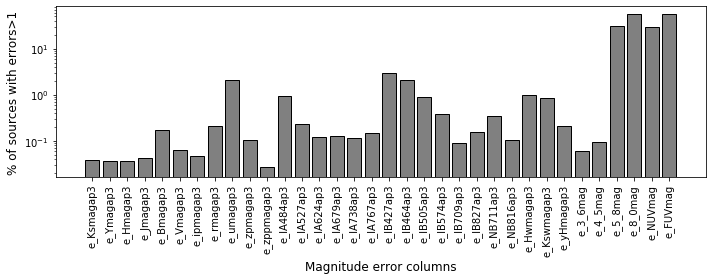

In [25]:
### Plot percentage of sources with big errors per band ###
# In current notebook we later leave only broad bands. For feature selection we could take another bands, but generally 
# it makes sense to select bands with low percentage of errors so that later during mag_err filtering we would not reduce 
# the size of the dataset significantly
errPercentage=np.array(errPercentage)
fig, axs = plt.subplots(1, 1,figsize=(10,4))
plt.xticks(rotation=90,size=10)
plt.yticks(size=10)
plt.yscale(value='log')
plt.xlabel('Magnitude error columns')
plt.ylabel('% of sources with errors>1')
axs.xaxis.label.set_size(12)
axs.yaxis.label.set_size(12)
axs.bar(list(errPercentage[:,0]),list(errPercentage[:,1].astype(float)),color='gray',edgecolor='black')
plt.tight_layout()

In [27]:
fig.savefig('magErr3.png',dpi=300)

In [28]:
### Drop columns from main Spectr-z crossmatched catalog ###
infoCols=['RAJ2000', 'DEJ2000', 'Seq', 'zphot', 'Instr','z_spec','Q_f']
magCols=['Ksmagap3', 'Ymagap3', 'Hmagap3', 'Jmagap3', 'Bmagap3', 
         'Vmagap3', 'ipmagap3', 'rmagap3', 'umagap3', 'zppmagap3']
magErrCols=['e_'+x for x in magCols]
allCols=tabCOSMOS_SpectrZ.colnames
colsToDrop = [x for x in allCols if x not in infoCols]
colsToDrop = [x for x in colsToDrop if x not in magCols]
colsToDrop = [x for x in colsToDrop if x not in magErrCols]
tabCOSMOS_SpectrZ.remove_columns(colsToDrop)

In [29]:
### Drop columns from DEIMOS crossmatched catalog ###
allCols=tabCOSMOS_DEIMOS.colnames
infoCols=['RAJ2000', 'DEJ2000', 'Seq', 'zphot', 'Instr','z_spec','Qf','Q']
colsToDrop = [x for x in allCols if x not in infoCols]
colsToDrop = [x for x in colsToDrop if x not in magCols]
colsToDrop = [x for x in colsToDrop if x not in magErrCols]
tabCOSMOS_DEIMOS.remove_columns(colsToDrop)

In [30]:
### Drop columns from COSMOS2015 catalog ###
allCols=tabCOSMOS2015.colnames
infoCols=['RAJ2000', 'DEJ2000', 'Seq', 'zphot']
magCols=['Ksmagap3', 'Ymagap3', 'Hmagap3', 'Jmagap3', 'Bmagap3', 
         'Vmagap3', 'ipmagap3', 'rmagap3', 'umagap3', 'zppmagap3']
magErrCols=['e_'+x for x in magCols]
colsToDrop = [x for x in allCols if x not in infoCols]
colsToDrop = [x for x in colsToDrop if x not in magCols]
colsToDrop = [x for x in colsToDrop if x not in magErrCols]
tabCOSMOS2015.remove_columns(colsToDrop)

In [31]:
### Check that we dropped out everything we wanted ###
print('Spectr-z catalog cols: \n', tabCOSMOS_SpectrZ.colnames)
print('DEIMOS catalog cols: \n', tabCOSMOS_DEIMOS.colnames)
print('COSMOS2015 catalog cols: \n', tabCOSMOS2015.colnames)

Spectr-z catalog cols: 
 ['RAJ2000', 'DEJ2000', 'Seq', 'Ksmagap3', 'e_Ksmagap3', 'Ymagap3', 'e_Ymagap3', 'Hmagap3', 'e_Hmagap3', 'Jmagap3', 'e_Jmagap3', 'Bmagap3', 'e_Bmagap3', 'Vmagap3', 'e_Vmagap3', 'ipmagap3', 'e_ipmagap3', 'rmagap3', 'e_rmagap3', 'umagap3', 'e_umagap3', 'zppmagap3', 'e_zppmagap3', 'zphot', 'Instr', 'z_spec', 'Q_f']
DEIMOS catalog cols: 
 ['RAJ2000', 'DEJ2000', 'Seq', 'Ksmagap3', 'e_Ksmagap3', 'Ymagap3', 'e_Ymagap3', 'Hmagap3', 'e_Hmagap3', 'Jmagap3', 'e_Jmagap3', 'Bmagap3', 'e_Bmagap3', 'Vmagap3', 'e_Vmagap3', 'ipmagap3', 'e_ipmagap3', 'rmagap3', 'e_rmagap3', 'umagap3', 'e_umagap3', 'zppmagap3', 'e_zppmagap3', 'zphot', 'z_spec', 'Qf', 'Q']
COSMOS2015 catalog cols: 
 ['RAJ2000', 'DEJ2000', 'Seq', 'Ksmagap3', 'e_Ksmagap3', 'Ymagap3', 'e_Ymagap3', 'Hmagap3', 'e_Hmagap3', 'Jmagap3', 'e_Jmagap3', 'Bmagap3', 'e_Bmagap3', 'Vmagap3', 'e_Vmagap3', 'ipmagap3', 'e_ipmagap3', 'rmagap3', 'e_rmagap3', 'umagap3', 'e_umagap3', 'zppmagap3', 'e_zppmagap3', 'zphot']


In [32]:
### Limit remaining mag_errs < 1###
tabCOSMOS_SpectrZ_MagErrLim=tabCOSMOS_SpectrZ
tabCOSMOS_DEIMOS_MagErrLim=tabCOSMOS_DEIMOS
tabCOSMOS2015_MagErrLim=tabCOSMOS2015
for name in magErrCols:
    tabCOSMOS_SpectrZ_MagErrLim=tabCOSMOS_SpectrZ_MagErrLim[((tabCOSMOS_SpectrZ_MagErrLim[name]>=0) 
                                                             & (tabCOSMOS_SpectrZ_MagErrLim[name]<=1))]
    tabCOSMOS_DEIMOS_MagErrLim=tabCOSMOS_DEIMOS_MagErrLim[((tabCOSMOS_DEIMOS_MagErrLim[name]>=0) 
                                                           & (tabCOSMOS_DEIMOS_MagErrLim[name]<=1))]
    tabCOSMOS2015_MagErrLim=tabCOSMOS2015_MagErrLim[((tabCOSMOS2015_MagErrLim[name]>=0) 
                                                     & (tabCOSMOS2015_MagErrLim[name]<=1))]

In [33]:
print('Num of objects in SpectrZ table: \t\t',len(tabCOSMOS_SpectrZ_MagErrLim))
print('Expected number of objects in SpectrZ table:\t\t 32547')
print('Num of objects in DEIMOS table:\t\t\t',len(tabCOSMOS_DEIMOS_MagErrLim))
print('Expected number of objects in DEIMOS table:\t\t 4485')
print('Num of objects in COSMOS2015 table:\t\t',len(tabCOSMOS2015_MagErrLim))
print('Expected number of objects in COSMOS2015 table:\t 259653')

Num of objects in SpectrZ table: 		 32547
Expected number of objects in SpectrZ table:		 32547
Num of objects in DEIMOS table:			 4485
Expected number of objects in DEIMOS table:		 4485
Num of objects in COSMOS2015 table:		 259653
Expected number of objects in COSMOS2015 table:	 259653


In [34]:
### Remove mag_err columns, since we don't need them further ###
errColsToDrop=[x for x in tabCOSMOS_SpectrZ_MagErrLim.colnames if x.startswith('e_')]
tabCOSMOS_SpectrZ_MagErrLim.remove_columns(errColsToDrop)
tabCOSMOS_DEIMOS_MagErrLim.remove_columns(errColsToDrop)
tabCOSMOS2015_MagErrLim.remove_columns(errColsToDrop)

In [35]:
### Read AGN catalog ###
tabAGNs=table.Table.read(fileNameAGN,format='fits')

In [36]:
### Remove AGNs from crossmatched main Spectr-z and DEIMOS catalogs ###
tabCOSMOS_SpectrZ_noAGN=tabCOSMOS_SpectrZ_MagErrLim[np.invert(np.isin(tabCOSMOS_SpectrZ_MagErrLim['Seq'],tabAGNs['Seq']))][:]
tabCOSMOS_DEIMOS_noAGN=tabCOSMOS_DEIMOS_MagErrLim[np.invert(np.isin(tabCOSMOS_DEIMOS_MagErrLim['Seq'],tabAGNs['Seq']))][:]
tabCOSMOS2015_noAGN=tabCOSMOS2015_MagErrLim[np.invert(np.isin(tabCOSMOS2015_MagErrLim['Seq'],tabAGNs['Seq']))][:]

In [37]:
### Perform Q_f filtering. Saving to csv since METAPHOR pipeline works only with this format ###
QfCol='Q_f'
tabCOSMOS_SpectrZ_QfFilter=filterQf(tabCOSMOS_SpectrZ_noAGN,QfCol,saveFlag=True,
                                    saveName="04_COSMOS_SpectrZ_QfFilter.csv",writeFormat='csv')
QfCol='Qf'
tabCOSMOS_DEIMOS_QfFilter=filterQf(tabCOSMOS_DEIMOS_noAGN,QfCol,saveFlag=True,
                                saveName="04_COSMOS_DEIMOS_QfFilter.csv",writeFormat='csv')

In [38]:
print('Num of objects in SpectrZ table: \t\t',len(tabCOSMOS_SpectrZ_QfFilter))
print('Expected number of objects in SpectrZ table:\t 20946')
print('Num of objects in DEIMOS table:\t\t\t',len(tabCOSMOS_DEIMOS_QfFilter))
print('Expected number of objects in DEIMOS table:\t 3684')
print('Num of objects in COSMOS2015 table:\t\t',len(tabCOSMOS2015_noAGN))
print('Expected number of objects in COSMOS2015 table:\t 259606')

Num of objects in SpectrZ table: 		 20946
Expected number of objects in SpectrZ table:	 20946
Num of objects in DEIMOS table:			 3684
Expected number of objects in DEIMOS table:	 3684
Num of objects in COSMOS2015 table:		 259606
Expected number of objects in COSMOS2015 table:	 259606


In [39]:
### Remove sources from Spectr-z catalog from COSMOS2015 and DEIMOS catalog. It is done to avoid biasing of statistics ###
tabCOSMOS2015_noSpectrZ=tabCOSMOS2015_noAGN[np.invert(np.isin(tabCOSMOS2015_noAGN['Seq'],tabCOSMOS_SpectrZ_QfFilter['Seq']))][:]
tabCOSMOS_DEIMOS_noSpectrZ=tabCOSMOS_DEIMOS_QfFilter[np.invert(np.isin(tabCOSMOS_DEIMOS_QfFilter['Seq'],tabCOSMOS_SpectrZ_QfFilter['Seq']))][:]

In [40]:
print('Num of objects in COSMOS2015 table: \t\t',len(tabCOSMOS2015_noSpectrZ))
print('Expected number of objects in COSMOS2015 table:\t 238660')
print('Num of objects in DEIMOS table: \t\t',len(tabCOSMOS_DEIMOS_noSpectrZ))
print('Expected number of objects in DEIMOS table:\t\t 2288')

Num of objects in COSMOS2015 table: 		 238660
Expected number of objects in COSMOS2015 table:	 238660
Num of objects in DEIMOS table: 		 2288
Expected number of objects in DEIMOS table:		 2288


In [41]:
tabCOSMOS_DEIMOS_noSpectrZ.columns

<TableColumns names=('RAJ2000','DEJ2000','Seq','Ksmagap3','Ymagap3','Hmagap3','Jmagap3','Bmagap3','Vmagap3','ipmagap3','rmagap3','umagap3','zppmagap3','zphot','z_spec','Qf','Q')>

In [42]:
np.max(tabCOSMOS_DEIMOS_noSpectrZ['ipmagap3'])

25.9069

In [43]:
### Remove from run (COSMOS2015) catalog instances that have mags bigger than in our train (Spectr-Z) catalog ###
workBands=[x for x in tabCOSMOS2015_noSpectrZ.colnames if x.endswith('magap3')]
for name in workBands:
    tabCOSMOS2015_noSpectrZ=tabCOSMOS2015_noSpectrZ[tabCOSMOS2015_noSpectrZ[name]<=np.max(tabCOSMOS_SpectrZ_QfFilter[name])]

In [44]:
print('Num of objects in COSMOS2015 table:\t\t',len(tabCOSMOS2015_noSpectrZ))
print('Expected number of objects in COSMOS2015 table:\t 228719')

Num of objects in COSMOS2015 table:		 228719
Expected number of objects in COSMOS2015 table:	 228719


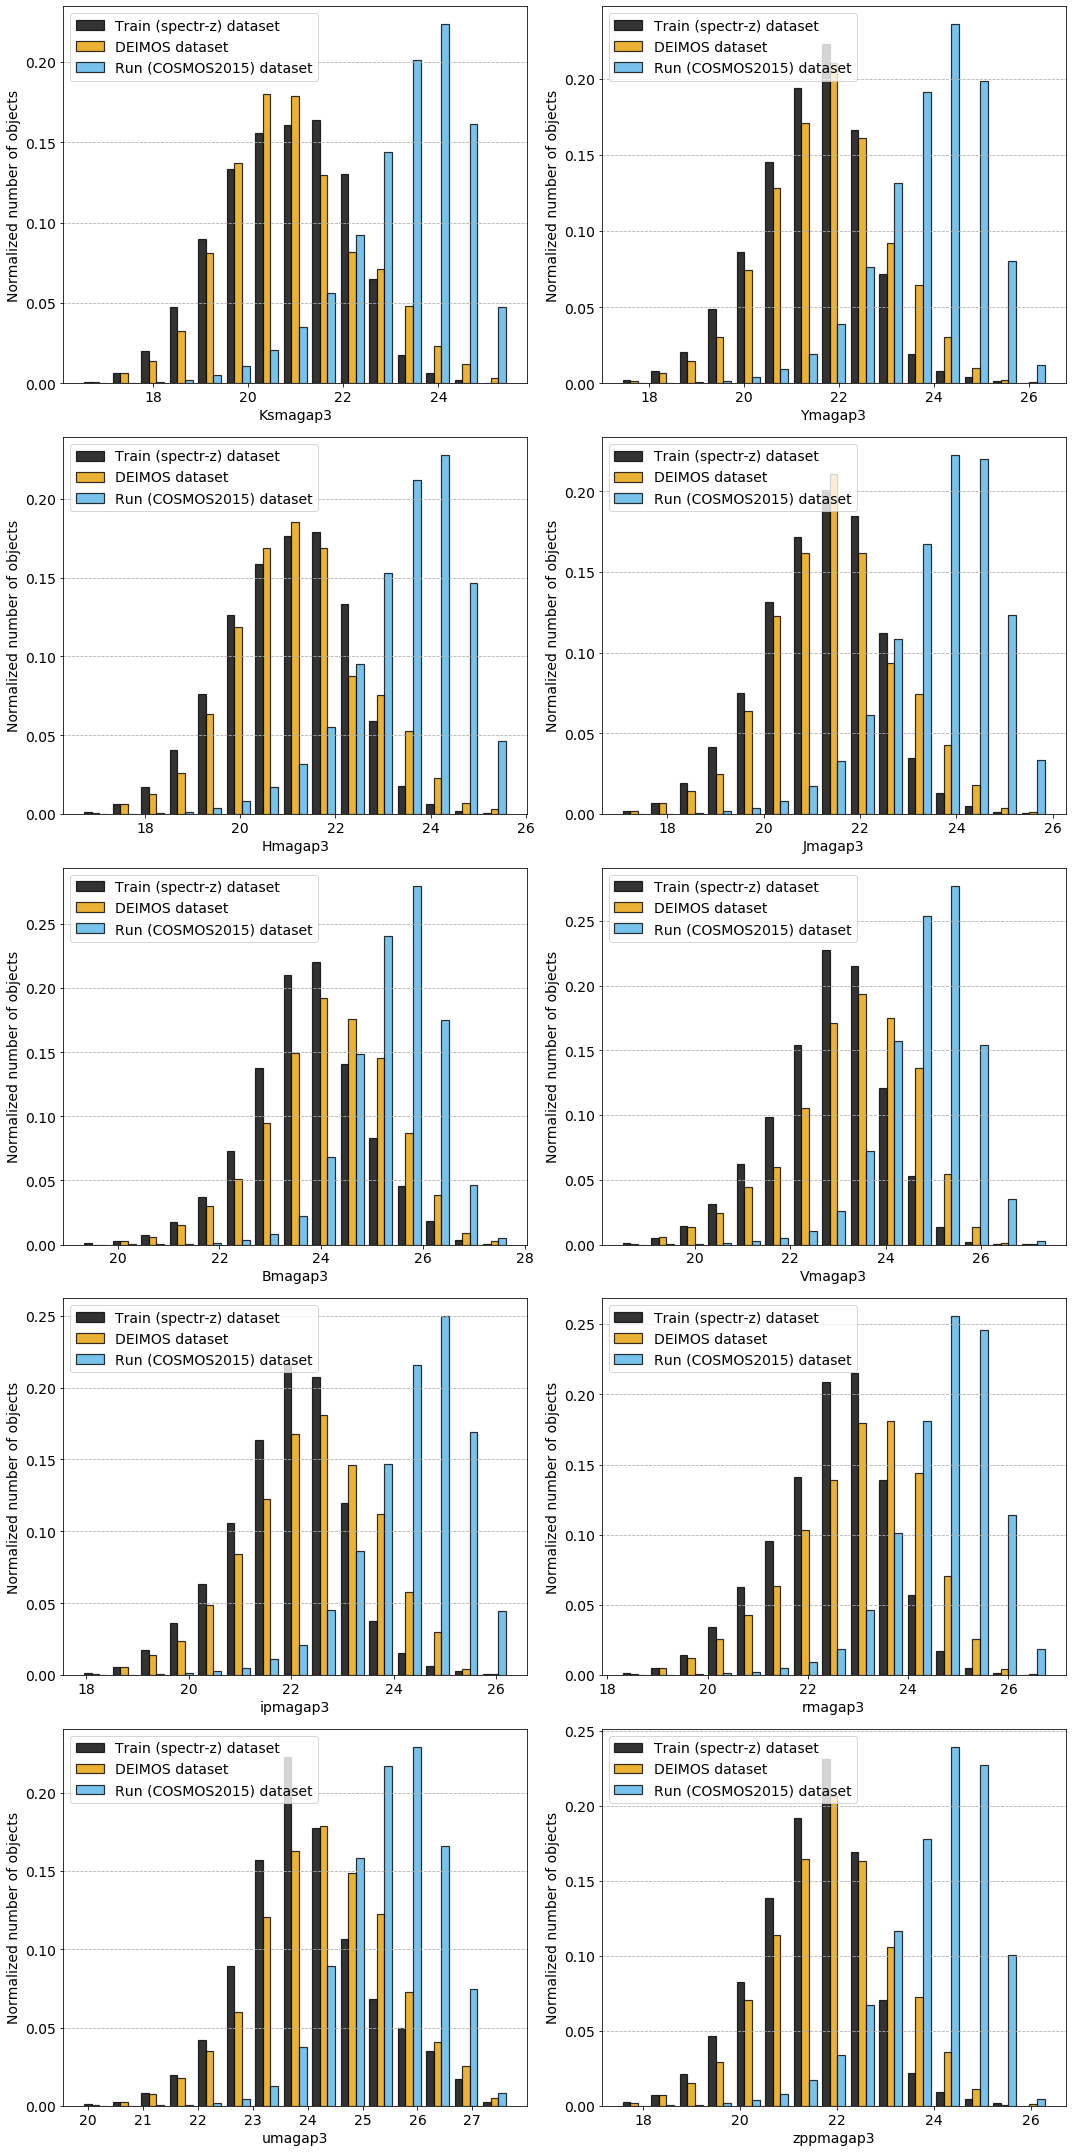

In [57]:
### Comparing mag distribution for spectr-z and COSMOS2015 catalogs ###
labels=['Train (spectr-z) dataset','DEIMOS dataset','Run (COSMOS2015) dataset']
numBins=15
h, w=5,2
fig, axs = plt.subplots(h,w,figsize=(15,30))
for i in range(h):
    for j in range(w):
        datasets=[tabCOSMOS_SpectrZ_QfFilter[workBands[i*w+j]],
                  tabCOSMOS_DEIMOS_QfFilter[workBands[i*w+j]],
                     tabCOSMOS2015_noSpectrZ[workBands[i*w+j]]]
        axs[i][j].grid(axis='y',linestyle ='--')
        plotMultiBar(datasets,numBins,labels,logScale=False,alpha=0.8,normCounts=True,xlabel=workBands[i*w+j],
                      ylabel='Normalized number of objects',axs=axs[i][j])
plt.tight_layout()

In [81]:
def plotMultiBar(datasets,numBins,labels,alpha,logScale=False,normCounts=False,saveFlag=False,
                  range=None, saveName='',xlabel='',ylabel='',axs=None,grayscale=False,textSize=14):
    if axs is None:
        axs = plt.gca()
        
    colorBlindPalette=['#56B4E9','#E69F00','#000000','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7']
    grayScalePalette=['#4c4c4c','#cccccc','#999999','#101010','#dedede']
    if grayscale==True:
        palette=grayScalePalette
    else:
        palette=colorBlindPalette 
    
    if logScale==True:
        axs.set_yscale('log')
    if normCounts==True:
        weights=[]
        for data in datasets:
            weight = np.ones_like(data)/float(len(data))
            weights.append(weight)
        n, bins, patches = axs.hist(datasets, bins=numBins,weights=weights,color=palette[:len(datasets)],
                 alpha=alpha, label=labels,edgecolor='black', linewidth=1.2, range=range,histtype='stepfilled')
        
    else:
        n, bins, patches = axs.hist(datasets,bins=numBins,color=palette[:len(datasets)],
                 alpha=alpha,label=labels,edgecolor='black', linewidth=1.2, range=range,histtype='stepfilled')  
    if grayscale==True:
        hatches = ['..', 'xx', '**','','|||']
        for patch_set, hatch in zip(patches, hatches):
            plt.setp(patch_set, hatch=hatch)
    axs.set_xlabel(xlabel,size=textSize)
    axs.set_ylabel(ylabel,size=textSize)
    
    axs.xaxis.set_tick_params(labelsize=textSize)
    axs.yaxis.set_tick_params(labelsize=textSize)
    axs.set_ylim(0,0.14)
    axs.legend(prop={'size': textSize},loc='upper left')

    if saveFlag==True:
        if saveName=="":
            print("Cannot save catalog: saveName is empty string")
        else:
            plt.savefig(saveName)
    return

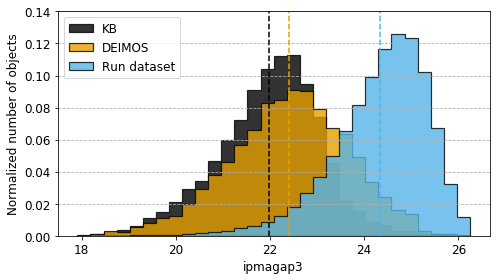

In [93]:
### Comparing mag distribution for spectr-z and COSMOS2015 catalogs ###
labels=['Run dataset','DEIMOS','KB']
numBins=30
h, w=1,1
fig, axs = plt.subplots(h,w,figsize=(7,4))
datasets=[tabCOSMOS2015_noSpectrZ['ipmagap3'],
         tabCOSMOS_DEIMOS_QfFilter['ipmagap3'],
         tabCOSMOS_SpectrZ_QfFilter['ipmagap3']]
axs.grid(axis='y',linestyle ='--')
plotMultiBar(datasets,numBins,labels,logScale=False,alpha=0.8,normCounts=True,xlabel='ipmagap3',
                      ylabel='Normalized number of objects',axs=axs,textSize=12)
axs.axvline(x=tabCOSMOS2015_noSpectrZ['ipmagap3'].mean(),ls='dashed',color='#56B4E9')
axs.axvline(x=tabCOSMOS_DEIMOS_QfFilter['ipmagap3'].mean(),ls='dashed',color='#E69F00')
axs.axvline(x=tabCOSMOS_SpectrZ_QfFilter['ipmagap3'].mean(),ls='dashed',color='#000000')
plt.tight_layout()

In [94]:
fig.savefig('runDeimosMagDistribsIPMAG.png',dpi=300)

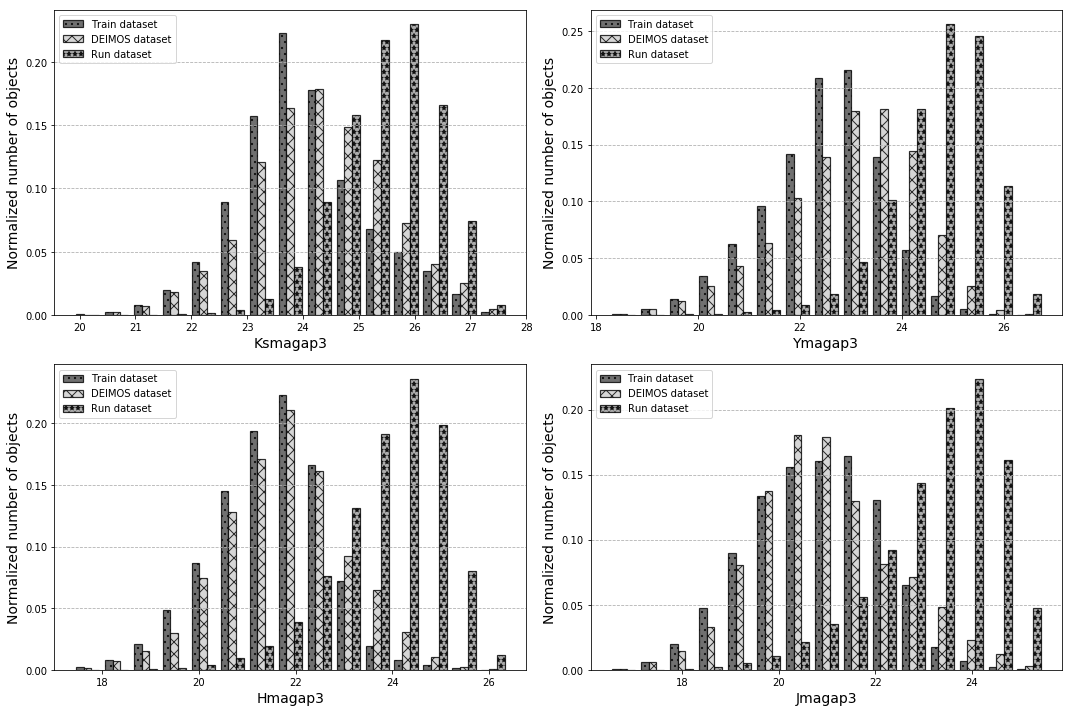

In [40]:
### Comparing mag distribution for spectr-z and COSMOS2015 catalogs ###
labels=['Train dataset','DEIMOS dataset','Run dataset']
articlePlotBands=['umagap3','rmagap3','Ymagap3','Ksmagap3']
numBins=15
h, w=2,2
fig, axs = plt.subplots(h,w,figsize=(15,10))
for i in range(h):
    for j in range(w):
        datasets=[tabCOSMOS_SpectrZ_QfFilter[articlePlotBands[i*w+j]],
                  tabCOSMOS_DEIMOS_QfFilter[articlePlotBands[i*w+j]],
                     tabCOSMOS2015_noSpectrZ[articlePlotBands[i*w+j]]]
        axs[i][j].grid(axis='y',linestyle ='--')
        plotMultiBar(datasets,numBins,labels,logScale=False,alpha=0.8,normCounts=True,xlabel=workBands[i*w+j],
                      ylabel='Normalized number of objects',axs=axs[i][j],grayscale=True)
plt.tight_layout()

In [41]:
fig.savefig('magDistribs2.eps')

In [47]:
tabCOSMOS2015_noSpectrZ.write('04_COSMOS2015_run.csv',format='csv')

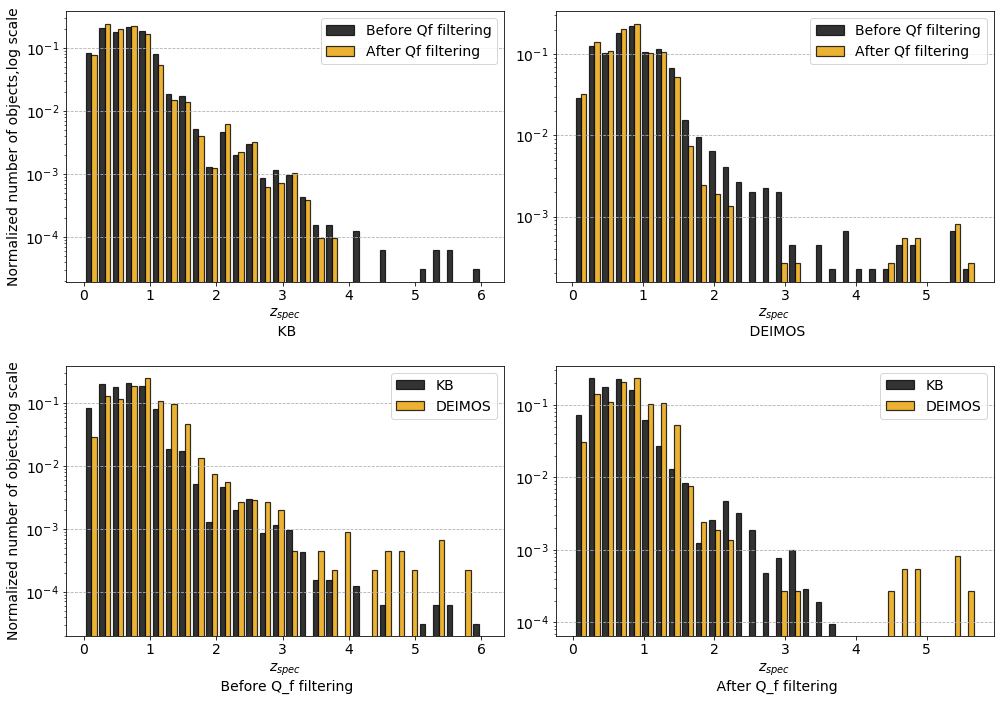

In [52]:
datasets=[tabCOSMOS_SpectrZ_MagErrLim['z_spec'],tabCOSMOS_SpectrZ_QfFilter['z_spec']]
labels=['Before Qf filtering','After Qf filtering']
numBins=30
fig, ((axs1,axs2),(axs3,axs4)) = plt.subplots(2, 2,figsize=(14,10))
axs1.grid(axis='y',linestyle ='--')
axs2.grid(axis='y',linestyle ='--')
plotMultiBar(datasets,numBins,labels,logScale=True,alpha=0.8,normCounts=True,
              xlabel='$z_{spec}$ \n KB',ylabel='Normalized number of objects,log scale',axs=axs1,grayscale=False)
datasets=[tabCOSMOS_DEIMOS_noAGN['z_spec'],tabCOSMOS_DEIMOS_QfFilter['z_spec']]
plotMultiBar(datasets,numBins,labels,logScale=True,alpha=0.8,normCounts=True,
              xlabel='$z_{spec}$ \n DEIMOS',ylabel=None,axs=axs2,grayscale=False)

datasets=[tabCOSMOS_SpectrZ_MagErrLim['z_spec'],tabCOSMOS_DEIMOS_noAGN['z_spec']]
labels=['KB','DEIMOS']
numBins=30
axs3.grid(axis='y',linestyle ='--')
axs4.grid(axis='y',linestyle ='--')
plotMultiBar(datasets,numBins,labels,logScale=True,alpha=0.8,normCounts=True,
              xlabel='$z_{spec}$ \n Before Q_f filtering',ylabel='Normalized number of objects,log scale',
             axs=axs3,grayscale=False)
datasets=[tabCOSMOS_SpectrZ_QfFilter['z_spec'],tabCOSMOS_DEIMOS_QfFilter['z_spec']]
plotMultiBar(datasets,numBins,labels,logScale=True,alpha=0.8,normCounts=True,
              xlabel='$z_{spec}$ \n After Q_f filtering',ylabel=None,axs=axs4,grayscale=False)

plt.tight_layout()


In [53]:
fig.savefig("beforeAfterQfFilteringColor.png", dpi=300)

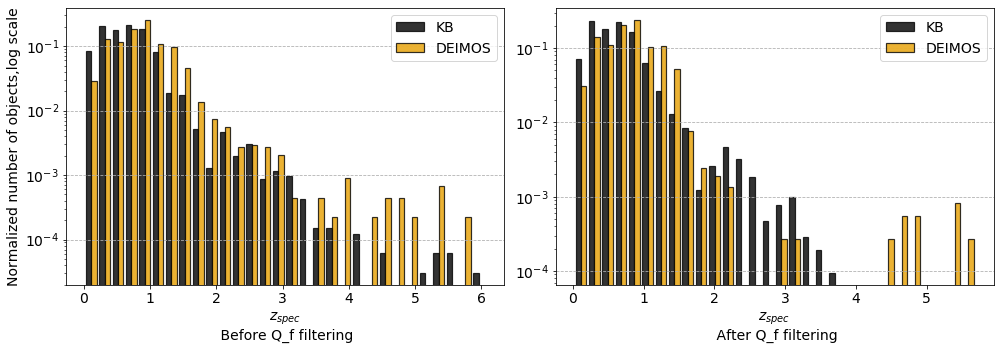

In [64]:
datasets=[tabCOSMOS_SpectrZ_MagErrLim['z_spec'],tabCOSMOS_DEIMOS_noAGN['z_spec']]
labels=['KB','DEIMOS']
numBins=30
fig, (axs1,axs2) = plt.subplots(1, 2,figsize=(14,5))
axs1.grid(axis='y',linestyle ='--')
axs2.grid(axis='y',linestyle ='--')
plotMultiBar(datasets,numBins,labels,logScale=True,alpha=0.8,normCounts=True,
              xlabel='$z_{spec}$ \n Before Q_f filtering',ylabel='Normalized number of objects,log scale',axs=axs1,grayscale=False)
datasets=[tabCOSMOS_SpectrZ_QfFilter['z_spec'],tabCOSMOS_DEIMOS_QfFilter['z_spec']]
plotMultiBar(datasets,numBins,labels,logScale=True,alpha=0.8,normCounts=True,
              xlabel='$z_{spec}$ \n After Q_f filtering',ylabel=None,axs=axs2,grayscale=False)
plt.tight_layout()

In [44]:
fig.savefig('spectrZ-beforeAfterQf.eps')

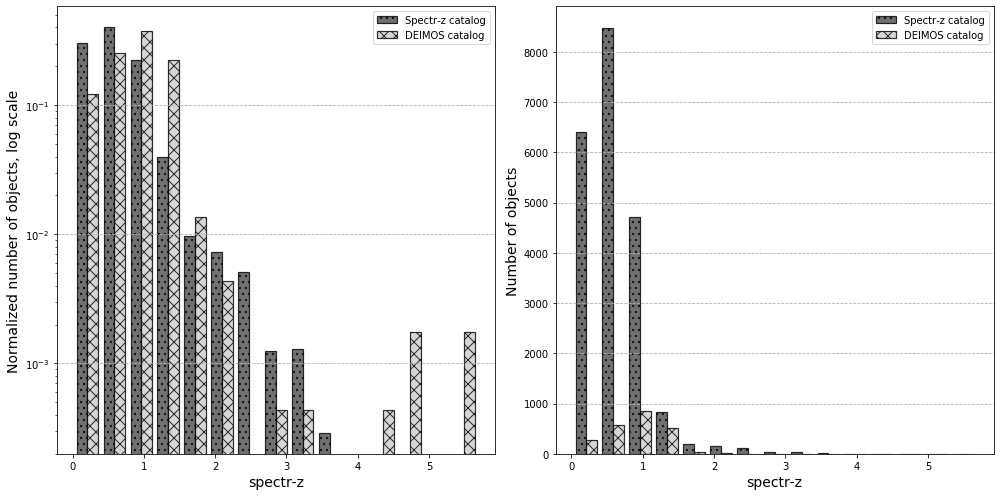

In [43]:
datasets=[tabCOSMOS_SpectrZ_QfFilter['z_spec'],tabCOSMOS_DEIMOS_noSpectrZ['z_spec']]
labels=['Spectr-z catalog','DEIMOS catalog']
numBins=15
fig, (axs1,axs2) = plt.subplots(1, 2,figsize=(14,7))
axs1.grid(axis='y',linestyle ='--')
axs2.grid(axis='y',linestyle ='--')
plotMultiBar(datasets,numBins,labels,logScale=True,alpha=0.8,normCounts=True,
              xlabel='spectr-z',ylabel='Normalized number of objects, log scale',axs=axs1,grayscale=True)
plotMultiBar(datasets,numBins,labels,logScale=False,alpha=0.8,normCounts=False,
              xlabel='spectr-z',ylabel='Number of objects',axs=axs2,grayscale=True)
plt.tight_layout()

In [46]:
tabCOSMOS_DEIMOS_noSpectrZ['z_spec'].min()

0.0256

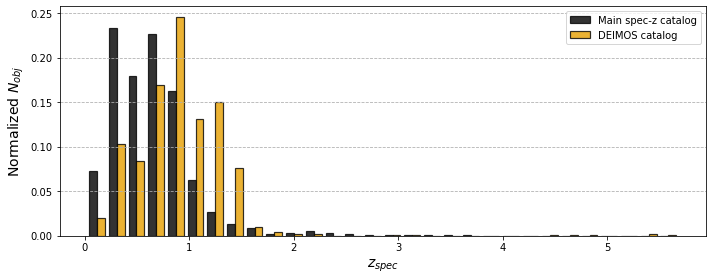

In [43]:
datasets=[tabCOSMOS_SpectrZ_QfFilter['z_spec'],tabCOSMOS_DEIMOS_noSpectrZ['z_spec']]
labels=['Main spec-z catalog','DEIMOS catalog']
numBins=30
fig, axs1 = plt.subplots(1, 1,figsize=(10,4))
axs1.grid(axis='y',linestyle ='--')
plotMultiBar(datasets,numBins,labels,logScale=False,alpha=0.8,normCounts=True,
              xlabel='$z_{spec}$',ylabel='Normalized $N_{obj}$',axs=axs1,grayscale=False)
plt.tight_layout()

In [70]:
fig.savefig('spectrZ-DEIMOS.eps')

In [47]:
### Checking how distribution by instruments changes after Q_f cleaning ###
instrNamesClean,instrCountsClean=np.unique(tabCOSMOS_SpectrZ_QfFilter['Instr'],return_counts=True)
instrClean=np.vstack([np.array(instrNamesClean,str),np.array(instrCountsClean)]).T
instrNamesFull,instrCountsFull=np.unique(tabCOSMOS_SpectrZ['Instr'],return_counts=True)
instrFull=np.vstack([np.array(instrNamesFull,str),np.array(instrCountsFull)]).T

In [ ]:
instrFull=pd.DataFrame(instrFull,columns=['Instr','Counts'])
instrClean=pd.DataFrame(instrClean,columns=['Instr','Counts'])
instrFull=instrFull.join(instrClean.set_index('Instr'),on='Instr',lsuffix='_Full', rsuffix='_Cleaned')
instrFull=instrFull.fillna(0)
print(instrFull)

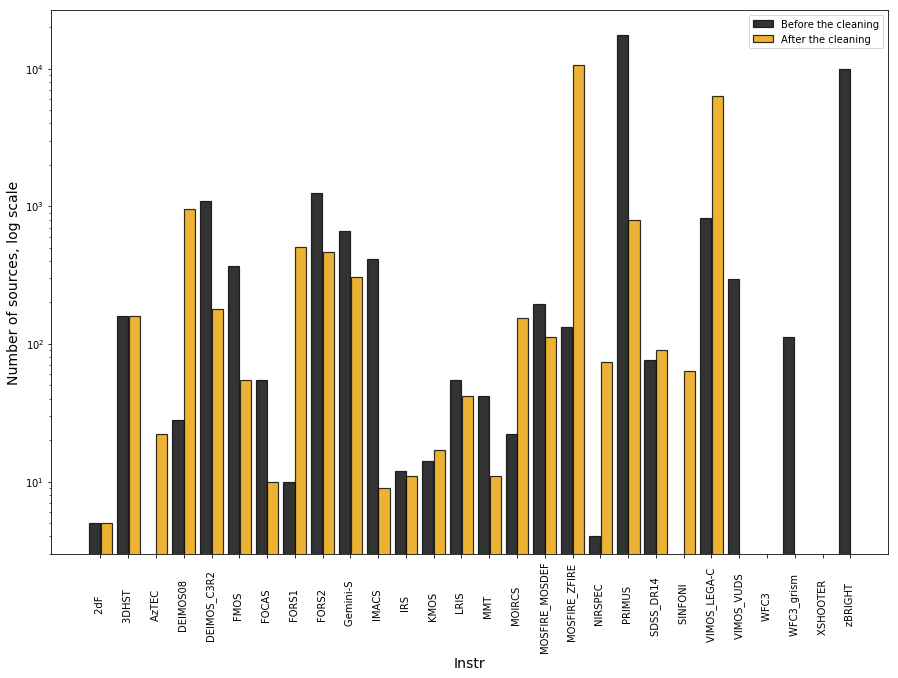

In [48]:
fig, axs = plt.subplots(1, 1,figsize=(15,10))
plt.xticks(rotation='vertical')
plt.yscale(value='log')
plt.xlabel('Instr',size=14)
plt.ylabel('Number of sources, log scale',size=14)
labelsFull=list(instrFull['Instr'])
xPositionsFull=np.arange(len(labelsFull))
width=0.4
plt.xticks(ticks=xPositionsFull,labels=labelsFull)
axs.bar(xPositionsFull-width/2-0.01,instrFull['Counts_Full'].astype(int),width,color='#000000',alpha=0.8,edgecolor='black', linewidth=1.2,label='Before the cleaning')
axs.bar(xPositionsFull+width/2+0.01,instrFull['Counts_Cleaned'].astype(int),width,color='#E69F00',alpha=0.8,edgecolor='black', linewidth=1.2,label='After the cleaning')
axs.legend(prop={'size': 10})

In [61]:
### We do not cut DEIMOS catalog by spectr-z since later we'll apply mag filtering 
# and we'll check how well it removes high-spectr-z objects ###
tabCOSMOS_SpectrZ_z1p7=tabCOSMOS_SpectrZ_QfFilter[tabCOSMOS_SpectrZ_QfFilter['z_spec']<=1.7]
tabCOSMOS_SpectrZ_z1p2=tabCOSMOS_SpectrZ_QfFilter[tabCOSMOS_SpectrZ_QfFilter['z_spec']<=1.2]
print('Num of objects in SpectrZ z<=1.7 table:\t\t\t ',len(tabCOSMOS_SpectrZ_z1p7))
print('Expected number of objects in COSMOS2015 z<=1.7 table:\t  20594')
print('Num of objects in SpectrZ z<=1.2 table:\t\t\t ',len(tabCOSMOS_SpectrZ_z1p2))
print('Expected number of objects in COSMOS2015 z<=1.2 table:\t  19893')

Num of objects in SpectrZ z<=1.7 table:			  20594
Expected number of objects in COSMOS2015 z<=1.7 table:	  20594
Num of objects in SpectrZ z<=1.2 table:			  19893
Expected number of objects in COSMOS2015 z<=1.2 table:	  19893


In [67]:
np.max(tabCOSMOS_SpectrZ_z1p2['ipmagap3'])

26.1881

In [57]:
tabCOSMOS_SpectrZ_z1p7.write('05_COSMOS_SpectrZ_Zlim_1p7.csv',format='csv')
tabCOSMOS_SpectrZ_z1p2.write('05_COSMOS_SpectrZ_Zlim_1p2.csv',format='csv')

In [68]:
### Remove from run (COSMOS2015) catalog instances that have mags bigger than in our train (Spectr-Z) catalog ###
workBands=[x for x in tabCOSMOS2015_noSpectrZ.colnames if x.endswith('magap3')]
for name in workBands:
    tabCOSMOS2015_z1p7=tabCOSMOS2015_noSpectrZ[tabCOSMOS2015_noSpectrZ[name]<=np.max(tabCOSMOS_SpectrZ_z1p7[name])]
    tabCOSMOS2015_z1p2=tabCOSMOS2015_noSpectrZ[tabCOSMOS2015_noSpectrZ[name]<=np.max(tabCOSMOS_SpectrZ_z1p2[name])]
print('Num of objects in COSMOS2015 z<=1.7 table:\t\t ',len(tabCOSMOS2015_z1p7))
print('Expected number of objects in COSMOS2015 z<=1.2 table:\t  228361')
print('Num of objects in COSMOS2015 z<=1.2 table:\t\t ',len(tabCOSMOS2015_z1p2))
print('Expected number of objects in COSMOS2015 z<=1.2 table:\t  228361')

Num of objects in COSMOS2015 z<=1.7 table:		  228361
Expected number of objects in COSMOS2015 z<=1.2 table:	  228361
Num of objects in COSMOS2015 z<=1.2 table:		  228361
Expected number of objects in COSMOS2015 z<=1.2 table:	  228361


In [71]:
np.median(tabCOSMOS2015_z1p2['ipmagap3'])

24.4932

In [67]:
tabCOSMOS2015_z1p7.write('05_COSMOS_1p7.csv',format='csv')
tabCOSMOS2015_z1p2.write('05_COSMOS_1p2.csv',format='csv')